The vertices of the path are:
[(0.0, 0.0, 0.0), (0.9755318327993396, -0.18275578878554954, -0.12222096735230356), (1.9457899815102473, -0.39824875470673204, -0.011939933177905954), (2.9183956317105024, -0.22247146268084517, 0.14018039027226617), (3.5098869280623832, -0.808597286016258, -0.41352943044554935), (4.395951888681981, -0.41876255802218615, -0.1626952812314129), (5.208368146005011, -0.47991666775000297, 0.4171667710712342), (5.986778217531063, 0.09216356469037335, 0.15870600383997246), (6.98125859960068, -0.009303067141168575, 0.13199847113045118), (7.747257455453925, -0.2012687626433809, 0.7455088007760666), (7.9267287746543, 0.6874214423515455, 1.1674326862466013), (7.687672865793295, 1.6269217834809486, 0.9220933672282798), (9.473304226264482, 3.4902832741507415, 4.103780967896897), (10.0, 5.0, 5.0)]

A path was found, with length: 16.93
The direct path is of length: 12.25
The RRT generation took: 0.67s
The Dijkstra path finding took: 0.0020003318786621094s


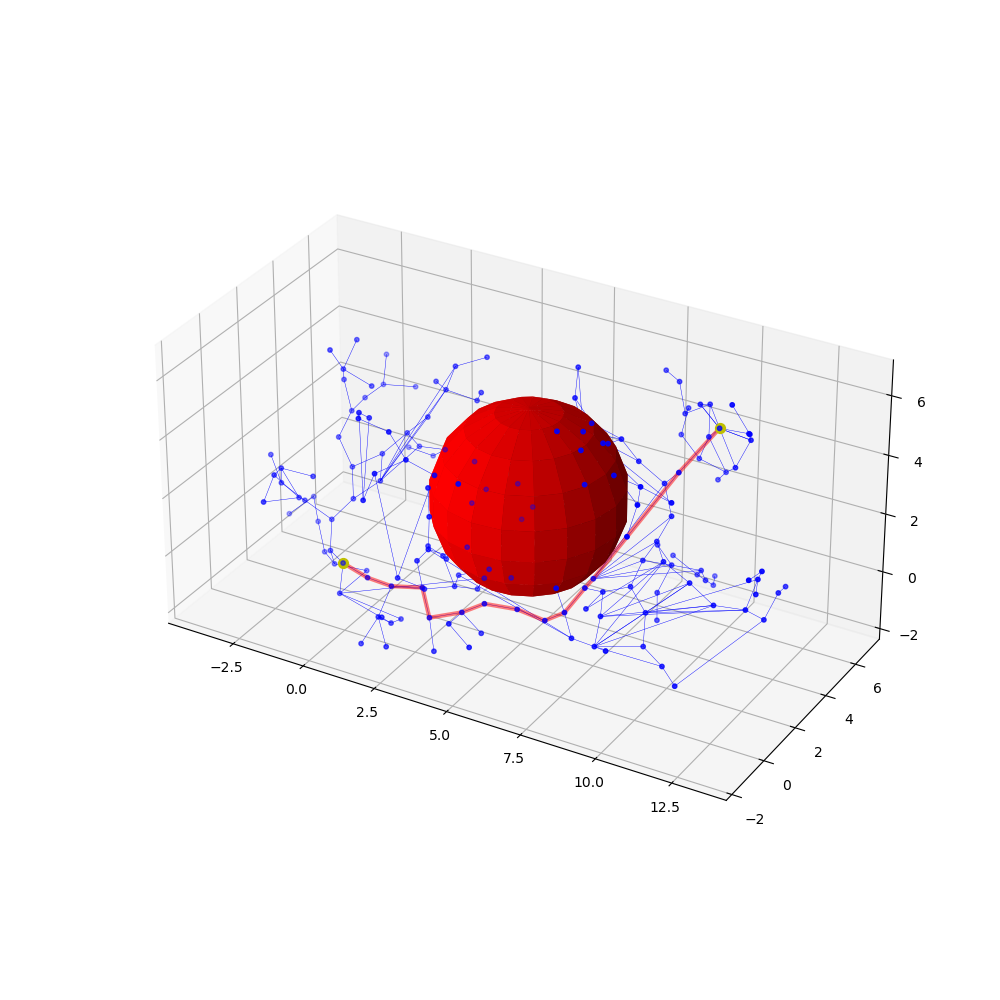

In [1]:
"""
Created on Mon Nov 28 21:26:12 2022

@author: Gebra
"""
# imports
%matplotlib widget

import math
import time
from random import random, randrange, uniform, choice

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
from collections import deque
# line class with some metrics to ease graph creation
class Line():
    # initialize some metrics
    def __init__(self, p0, p1):
        self.p0 = np.array(p0)
        self.p1 = np.array(p1)
        self.direction = np.array(p1) - np.array(p0)
        self.distance = np.linalg.norm(self.direction)
        self.direction = self.direction/self.distance # normalize

    def path(self, t):
        return self.p0 + t * self.dirn

# graph class
class Graph:
    # initialize some metrix
    def __init__(self, startposition, endposition):
        self.startposition = startposition
        self.endposition = endposition
        self.found_path = False
        # size of searchbox
        self.searchboxsize_x = (startposition[0] - endposition[0])
        self.searchboxsize_y = (startposition[1] - endposition[1])
        self.searchboxsize_z = (startposition[2] - endposition[2])
        # location of seachbox startpoint: two times size of box between start and end position
        self.searchbegin_x = self.startposition[0] + (self.searchboxsize_x/2) 
        self.searchbegin_y = self.startposition[1] + (self.searchboxsize_y/2) 
        self.searchbegin_z = self.startposition[2] + (self.searchboxsize_z/2) 
        
        self.vertices = [startposition]
        self.edges = [] # contains the indices of the vertices
        self.indices = {startposition:0} # dictonary with indices for the vertices
        self.distances = {0:0.} # dictonary with distances for each index
        self.connections = {0:[]} # dictonary with connecting node(s)
        
    # creating a random position within search frame
    def randpos(self, obstacles = None, rand_radius = None, bias = None, obstacle_bias = False):
        if obstacle_bias == False:
            # create random values between 0 and 1
            x = random()
            y = random()
            z = random()
            # convert to value within searchbox
            posx = self.searchbegin_x - x*self.searchboxsize_x*2
            posy = self.searchbegin_y - y*self.searchboxsize_y*2
            posz = self.searchbegin_z - z*self.searchboxsize_z*2
            
        else:
            select = random()
            if select > bias:
                # create random values between 0 and 1
                x = random()
                y = random()
                z = random()
                # convert to value within searchbox
                posx = self.searchbegin_x - x*self.searchboxsize_x*2
                posy = self.searchbegin_y - y*self.searchboxsize_y*2
                posz = self.searchbegin_z - z*self.searchboxsize_z*2
            else:
                rand_obs = randrange(0,len(obstacles))
                direction = np.array((uniform(-1,1), uniform(-1,1), uniform(-1,1)))
                length = np.linalg.norm(direction)
                rand_pos = (direction/length)*(obstacles[rand_obs][3] + uniform(0.,rand_radius))
                posx = obstacles[rand_obs][0]+ rand_pos[0]
                posy = obstacles[rand_obs][1]+ rand_pos[1]
                posz = obstacles[rand_obs][2]+ rand_pos[2]
                
        return posx, posy, posz
    def add_vertex(self, vertex):
        try: # check if vertex already exists
            idx = self.indices[vertex]
        except:# otherwise add to list and dictionaries
            idx = len(self.vertices)
            self.vertices.append(vertex)
            self.indices[vertex] = idx
            self.connections[idx] = []
        return idx

    def add_edge(self, idx1, idx2, cost):
        self.edges.append((idx1, idx2)) # add edge based on indices
        self.connections[idx1].append((idx2, cost)) #add the connecting nodes and costs
        self.connections[idx2].append((idx1, cost))

# RRT algorithm
def RRT(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize):
    RRT_Graph = Graph(startposition, endposition)
    
    for i in range(iterations):
        randpos = RRT_Graph.randpos(obstacles, rand_radius, bias, obstacle_bias)
        
        if in_obstacle(obstacles, randpos):
            continue
            
        near_vex, near_idx = nearest_node(RRT_Graph, randpos, obstacles)
        if near_vex is None:
            continue
        
        if stepsize is not None:
            randpos = reshape(randpos, near_vex, stepsize)
        
        new_idx = RRT_Graph.add_vertex(randpos)
        dist = distance(near_vex,randpos)
        RRT_Graph.add_edge(new_idx,near_idx,dist)
        
        end_distance = distance(randpos,RRT_Graph.endposition)
        if end_distance < threshold:
            end_index = RRT_Graph.add_vertex(RRT_Graph.endposition)
            RRT_Graph.add_edge(new_idx,end_index,end_distance)
            RRT_Graph.found_path = True
    return RRT_Graph

# RRT* algorithm
def RRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize):
    RRT_Graph = Graph(startposition, endposition)
    gamma = 10*stepsize*pow((1+1/3),(1/3))
    for i in range(iterations):
        randpos = RRT_Graph.randpos(obstacles, rand_radius, bias, obstacle_bias)
        
        #if RRT_Graph.found_path:
            
        if in_obstacle(obstacles, randpos):
            continue
            
        near_vex, near_idx = nearest_node(RRT_Graph, randpos, obstacles)
        if near_vex is None:
            continue
        
        if stepsize is not None:
            randpos = reshape(randpos, near_vex, stepsize)
        
        new_idx = RRT_Graph.add_vertex(randpos)
        dist = distance(near_vex,randpos)
        RRT_Graph.add_edge(new_idx,near_idx,dist)
        RRT_Graph.distances[new_idx] = RRT_Graph.distances[near_idx] + dist #update the distances
        n = len(RRT_Graph.vertices)
        
        # update nearby vertices distance (if shorter)
        for vertex in RRT_Graph.vertices:
            if vertex == randpos:
                continue

            dist = distance(vertex, randpos)
            if dist > gamma*pow((np.log(n)/n),1/3):
                continue
                
            line = Line(vertex, randpos)
            if trough_obstacle(obstacles, line):
                continue

            idx = RRT_Graph.indices[vertex]
            if (RRT_Graph.distances[new_idx] + dist) < (RRT_Graph.distances[idx]):
                RRT_Graph.add_edge(idx, new_idx, dist)
                RRT_Graph.distances[idx] = RRT_Graph.distances[new_idx] + dist

        
        end_distance = distance(randpos,RRT_Graph.endposition)
        if end_distance < threshold:
            end_index = RRT_Graph.add_vertex(RRT_Graph.endposition)
            RRT_Graph.add_edge(new_idx,end_index,end_distance)
            try:
                RRT_Graph.distances[end_index] = min(RRT_Graph.distances[end_index], RRT_Graph.distances[new_idx]+end_distance)
            except:
                RRT_Graph.distances[end_index] = RRT_Graph.distances[new_idx]+end_distance

            RRT_Graph.found_path = True
    return RRT_Graph

# Informed RRT* algorithm
def iRRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize):
    RRT_Graph = Graph(startposition, endposition)
    gamma = 10*stepsize*pow((1+1/3),(1/3))
    for i in range(iterations):
        randpos = RRT_Graph.randpos(obstacles, rand_radius, bias, obstacle_bias)
        
        if RRT_Graph.found_path:
            found_path = dijkstra(RRT_Graph)
            length = 0.
            for path in range(len(found_path)-1):
                length = length + distance((found_path[path][0],found_path[path][1],found_path[path][2]),(found_path[path+1][0],found_path[path+1][1],found_path[path+1][2]))
            if not in_ellipsoid(startposition, endposition, randpos, length):
                
                continue
            
            
            
        if in_obstacle(obstacles, randpos):
            continue
            
        near_vex, near_idx = nearest_node(RRT_Graph, randpos, obstacles)
        if near_vex is None:
            continue
        
        if stepsize is not None:
            randpos = reshape(randpos, near_vex, stepsize)
        
        new_idx = RRT_Graph.add_vertex(randpos)
        dist = distance(near_vex,randpos)
        RRT_Graph.add_edge(new_idx,near_idx,dist)
        RRT_Graph.distances[new_idx] = RRT_Graph.distances[near_idx] + dist #update the distances
        
        n = len(RRT_Graph.vertices)
        # update nearby vertices distance (if shorter)
        for vertex in RRT_Graph.vertices:
            if vertex == randpos:
                continue

            dist = distance(vertex, randpos)
            if dist > gamma*pow((np.log(n)/n),1/3):
                continue
                
            line = Line(vertex, randpos)
            if trough_obstacle(obstacles, line):
                continue

            idx = RRT_Graph.indices[vertex]
            if (RRT_Graph.distances[new_idx] + dist) < (RRT_Graph.distances[idx]):
                RRT_Graph.add_edge(idx, new_idx, dist)
                RRT_Graph.distances[idx] = RRT_Graph.distances[new_idx] + dist

        
        end_distance = distance(randpos,RRT_Graph.endposition)
        if end_distance < threshold:
            end_index = RRT_Graph.add_vertex(RRT_Graph.endposition)
            RRT_Graph.add_edge(new_idx,end_index,end_distance)
            try:
                RRT_Graph.distances[end_index] = min(RRT_Graph.distances[end_index], RRT_Graph.distances[new_idx]+end_distance)
            except:
                RRT_Graph.distances[end_index] = RRT_Graph.distances[new_idx]+end_distance

            RRT_Graph.found_path = True
        
    
    return RRT_Graph

# Plotting function
def plot_graph(Graph, obstacles, startposition, endposition, RRT_time, found_path = None, dijkstra_time = None):
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes(projection ='3d')
    vertices = np.asarray(Graph.vertices)
   
    size_x = max(vertices[:,0:1]) - min(vertices[:,0:1])
    size_y = max(vertices[:,1:2]) - min(vertices[:,1:2])
    size_z = max(vertices[:,2:]) - min(vertices[:,2:])
    
    vex_x = [x for x, y, z in Graph.vertices]
    vex_y = [y for x, y, z in Graph.vertices]
    vex_z = [z for x, y, z in Graph.vertices]
    
    for obstacle in range(len(obstacles)):
        u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
        x = obstacles[obstacle][0]+obstacles[obstacle][3]*np.cos(u)*np.sin(v)
        y = obstacles[obstacle][1]+obstacles[obstacle][3]*np.sin(u)*np.sin(v)
        z = obstacles[obstacle][2]+obstacles[obstacle][3]*np.cos(v)
        ax.plot_surface(x, y, z, color="r")
    
    ax.scatter(vex_x,vex_y,vex_z, s=10, color="b")
    ax.scatter(Graph.startposition[0],Graph.startposition[1],Graph.startposition[2],s=50, color="y")
    ax.scatter(Graph.endposition[0],Graph.endposition[1],Graph.endposition[2],s=50, color="y")
    
    for edge in Graph.edges:
        x = np.array([Graph.vertices[edge[0]][0],Graph.vertices[edge[1]][0]])
        y = np.array([Graph.vertices[edge[0]][1],Graph.vertices[edge[1]][1]])
        z = np.array([Graph.vertices[edge[0]][2],Graph.vertices[edge[1]][2]])
        ax.plot3D(x, y, z, color="b",linewidth=0.3)
    
    if found_path is not None:
        length = 0.
        for path in range(len(found_path)-1):
            x = np.array([found_path[path][0],found_path[path+1][0]])
            y = np.array([found_path[path][1],found_path[path+1][1]])
            z = np.array([found_path[path][2],found_path[path+1][2]])
            length = length + distance((found_path[path][0],found_path[path][1],found_path[path][2]),(found_path[path+1][0],found_path[path+1][1],found_path[path+1][2]))
            ax.plot3D(x, y, z, color="r",linewidth=3, alpha=0.5)
        print('A path was found, with length:', round(length,2))
        print('The direct path is of length:', round(distance(startposition,endposition),2))
        print('The RRT generation took: '+str(round(RRT_time,2))+ 's')
        print('The Dijkstra path finding took: '+str(dijkstra_time)+'s')
   
    if found_path is None:
        print('No path was found.')
        print('The RRT generation took: '+str(round(RRT_time,2))+ 's')
        
    ax.set_box_aspect(aspect = (size_x/size_z,size_y/size_z,1))
    #ax.set_aspect('equal', adjustable='box')
    plt.show()
    
    
    

# calculate intersection between line and obstacle
# still needs some work, only works for spheres
def intersection(obstacle, line):
    r = obstacle[3]
    C = obstacle[:3]
    P = line.p0
    U = line.direction
    Q=P-C
    a = np.dot(U,U)
    b= 2*np.dot(U,Q)
    c = np.dot(Q,Q)-r*r
    d = np.dot(b,b)-4*np.dot(a,c)
    if (line.p0[0] > (obstacle[0]+r) and line.p1[0] > (obstacle[0]+r)) or (line.p0[0] < (obstacle[0]-r) and line.p1[0] < (obstacle[0]-r)) or (line.p0[1] > (obstacle[1]+r) and line.p1[1] > (obstacle[1]+r)) or (line.p0[1] < (obstacle[1]-r) and line.p1[1] < (obstacle[1]-r)) or (line.p0[2] > (obstacle[2]+r) and line.p1[2] > (obstacle[2]+r)) or (line.p0[2] < (obstacle[2]-r) and line.p1[2] < (obstacle[2]-r)):
        return False
    if d < 0:
        return False
    return True

# determine distance between 2 points
def distance(x, y):
    return np.linalg.norm(np.array(x) - np.array(y))

# determine whether a vertex (point) is in one of the obstacles
def in_obstacle(obstacles, vertex):
    for obstacle in obstacles:
        if distance(obstacle[:3],vertex) < obstacle[3]:
            return True
    return False

# determine whether a edge (line) goes through one of the obstacles
def trough_obstacle(obstacles,line):
    for obstacle in obstacles:
        if intersection(obstacle, line):
            return True
    return False

#find the nearest node
def nearest_node(Graph, vertex, obstacles):
    near_vex = None
    near_idx = None
    min_distance = 10.e10
    for idx, graph_vertex in enumerate(Graph.vertices):
        line = Line(graph_vertex, vertex)
        if trough_obstacle(obstacles,line):
            continue
        
        dist = distance(graph_vertex, vertex)
        if dist < min_distance:
            min_distance = dist
            near_idx = idx
            near_vex = graph_vertex
    return near_vex, near_idx

def reshape(randpos, near_vex, stepsize):
    direction = np.array(randpos) - np.array(near_vex)
    length = np.linalg.norm(direction)
    direction = (direction / length) * min (stepsize, length) # find whether stepsize or length is smallest

    shortend_vertex = (near_vex[0]+direction[0], near_vex[1]+direction[1], near_vex[2]+direction[2]) # create a shorter line
    return shortend_vertex

def average(lst):
    try:
        average = sum(lst) / len(lst)
    except:
        average = None
    return average

#define rotated ellipsoid for informed RRT*
def in_ellipsoid(startposition, endposition, pos, path_length):
    startposition = np.array(startposition)
    endposition = np.array(endposition)
    c_min = np.linalg.norm(endposition - startposition)
    c_best = path_length
    a_squared = 0.25 * (np.square(c_best)+np.square(c_min))
    c_squared = np.square(0.5*c_best)
    r = (endposition-startposition)/np.linalg.norm(endposition-startposition)
    p = 0.5 * endposition + startposition
    z_squared = np.square((np.dot((pos-p),r)))
    xy_squared = np.dot((pos-p),(pos-p))-z_squared
                          
    if (xy_squared/a_squared + z_squared/c_squared) < 1:
        return True
    else:
        return False
    
    
def dijkstra(Graph):
    
    # Dijkstra algorithm for finding shortest path from start position to end, from MIT License Copyright (c) 2019 Fanjin Zeng
    
    srcIdx = Graph.indices[Graph.startposition]
    dstIdx = Graph.indices[Graph.endposition]

    # build dijkstra
    nodes = list(Graph.connections.keys())
    dist = {node: float('inf') for node in nodes}
    prev = {node: None for node in nodes}
    dist[srcIdx] = 0

    while nodes:
        curNode = min(nodes, key=lambda node: dist[node])
        nodes.remove(curNode)
        if dist[curNode] == float('inf'):
            break

        for neighbor, cost in Graph.connections[curNode]:
            newCost = dist[curNode] + cost
            if newCost < dist[neighbor]:
                dist[neighbor] = newCost
                prev[neighbor] = curNode

    # retrieve path
    path = deque()
    curNode = dstIdx
    while prev[curNode] is not None:
        path.appendleft(Graph.vertices[curNode])
        curNode = prev[curNode]
    path.appendleft(Graph.vertices[curNode])
    return list(path)

if __name__ == '__main__':
       
    startposition = (0.,0.,0.)
    endposition = (10.,5.,5.)
    #obstacles = []
    obstacles = [(5.,2.5,2.5,3)]
    #obstacles = [(1.,1.,1.,.5),(3.,4.,5.,1.),(4,2,3,1),(6,3,1,2),(6,1,1,2),(8,1,4,1)]
    #obstacles = [(5,-1,-1,1.5),(5,1,-1,1.5),(5,3,-1,1.5),(5,5,-1,1.5),(5,-1,1,1.5),(5,1,1,1.5),(5,3,1,1.5),(5,5,1,1.5),(5,-1,3,1.5),(5,3.5,3,1.5),(5,0,3,1.5),(5,5,3,1.5),(5,-1,5,1.5),(5,1,5,1.5),(5,3,5,1.5),(5,5,5,1.5)] #dense
    iterations = 200
    threshold = 2. #for marking the end position as found
    stepsize = 1. # stepsize of newly generated vertices
    
    #some parameters for the obstacle bias attempt
    obstacle_bias = False
    bias = 0.2
    rand_radius = 0.5
    
    start_RRT = time.time() #record start time
    #G = RRT(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
    #G = RRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
    G = iRRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
    
    end_RRT = time.time()
    RRT_time = end_RRT - start_RRT
    if G.found_path:
        start_dijkstra = time.time()
        path = dijkstra(G)
        end_dijkstra = time.time()
        dijkstra_time = end_dijkstra - start_dijkstra
        print('The vertices of the path are:')
        print(path)
        print()
        plot_graph(G, obstacles, startposition, endposition, RRT_time, path, dijkstra_time)
    else:
        plot_graph(G, obstacles, startposition, endposition, RRT_time)
    
   


In [ ]:
# Doing many iterations and compare, will take some time
if __name__ == '__main__':
    
    startposition = (0.,0.,0.)
    endposition = (10.,5.,5.)
    obstacles = [(1.,1.,1.,.5),(3.,4.,5.,1.),(4,2,3,1),(6,3,1,2),(6,1,1,2),(8,1,4,1)]
    iterations = 200
    threshold = 2. #for marking the end position as found
    stepsize = 1. # stepsize of newly generated vertices
    
    #some parameters for the obstacle bias attempt
    obstacle_bias = False
    bias = 0.2
    rand_radius = 0.5
    
    sample_size = 100
    
    RRT_times = []
    RRT_lengths = []
    RRT_succesrate = 0
    for sample in range(sample_size):
        
        start_RRT = time.time() #record start time
        G = RRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
        end_RRT = time.time()
        RRT_time = end_RRT - start_RRT
        RRT_times.append(RRT_time)
        if G.found_path:
            found_path = dijkstra(G)
            length = 0.
            for path in range(len(found_path)-1):
                length = length + distance((found_path[path][0],found_path[path][1],found_path[path][2]),(found_path[path+1][0],found_path[path+1][1],found_path[path+1][2]))
            RRT_lengths.append(length)
            RRT_succesrate = RRT_succesrate + 1
        else:
            RRT_succesrate = RRT_succesrate
    
    average_RRT_time = average(RRT_times)
    average_RRT_length = average(RRT_lengths)
    RRT_succes_percentage = (RRT_succesrate/sample_size)*100
    
    obstacle_bias = True
    BRRT_times = []
    BRRT_lengths = []
    BRRT_succesrate = 0
    for sample in range(sample_size):
        
        start_RRT = time.time() #record start time
        G = RRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
        end_RRT = time.time()
        BRRT_time = end_RRT - start_RRT
        BRRT_times.append(BRRT_time)
        if G.found_path:
            found_path = dijkstra(G)
            length = 0.
            for path in range(len(found_path)-1):
                length = length + distance((found_path[path][0],found_path[path][1],found_path[path][2]),(found_path[path+1][0],found_path[path+1][1],found_path[path+1][2]))
            BRRT_lengths.append(length)
            BRRT_succesrate = BRRT_succesrate + 1
        else:
            BRRT_succesrate = BRRT_succesrate
    
    average_BRRT_time = average(BRRT_times)
    average_BRRT_length = average(BRRT_lengths)
    BRRT_succes_percentage = (BRRT_succesrate/sample_size)*100
    
    print('The direct path is of length:', round(distance(startposition,endposition),2))
    print('The average time for RRT was: '+str(round(average_RRT_time,2))+ 's')
    print('The average time for Biased RRT was: '+str(round(average_BRRT_time,2))+ 's')
    print('The average length for RRT was: '+str(round(average_RRT_length,2)))
    print('The average length for Biased RRT was: '+str(round(average_BRRT_length,2)))
    print('The RRT generation had a succesrate of: '+str(round(RRT_succes_percentage,2))+ '%')
    print('The Biased RRT generation had a succesrate of: '+str(round(BRRT_succes_percentage,2))+ '%')

In [2]:
# Evaluate at various bias settings, will take some time


startposition = (0.,0.,0.)
endposition = (10.,5.,5.)
obstacles = [(5.,2.5,2.5,3)]
iterations = 300
threshold = 2. #for marking the end position as found
stepsize = 1. # stepsize of newly generated vertices

#some parameters for the obstacle bias attempt
obstacle_bias = True
bias_list = np.linspace(0,0.8,9)
print(bias_list)
rand_radius = 0.5

sample_size = 5

average_BRRT_times = []
average_BRRT_lengths = []
BRRT_succes_percentages = []
std_BRRT_times = []
std_BRRT_lengths = []

average_BRRTs_times = []
average_BRRTs_lengths = []
BRRTs_succes_percentages = []
std_BRRTs_times = []
std_BRRTs_lengths = []

average_iBRRTs_times = []
average_iBRRTs_lengths = []
iBRRTs_succes_percentages = []
std_iBRRTs_times = []
std_iBRRTs_lengths = []

for bias in bias_list:
    BRRT_times = []
    BRRT_lengths = []
    BRRT_succesrate = 0
    for sample in range(sample_size):

        start_RRT = time.time() #record start time
        G = RRT(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
        end_RRT = time.time()
        BRRT_time = end_RRT - start_RRT
        BRRT_times.append(BRRT_time)
        if G.found_path:
            found_path = dijkstra(G)
            length = 0.
            for path in range(len(found_path)-1):
                length = length + distance((found_path[path][0],found_path[path][1],found_path[path][2]),(found_path[path+1][0],found_path[path+1][1],found_path[path+1][2]))
            BRRT_lengths.append(length)
            BRRT_succesrate = BRRT_succesrate + 1
        else:
            BRRT_succesrate = BRRT_succesrate

    average_BRRT_time = average(BRRT_times)
    average_BRRT_length = average(BRRT_lengths)
    BRRT_succes_percentage = (BRRT_succesrate/sample_size)*100
    std_BRRT_time = np.std(BRRT_times)
    if len(BRRT_lengths) == 0:
        std_BRRT_length = 0
    else:
        std_BRRT_length = np.std(BRRT_lengths)

    average_BRRT_times.append(average_BRRT_time)
    average_BRRT_lengths.append(average_BRRT_length)
    BRRT_succes_percentages.append(BRRT_succes_percentage)
    std_BRRT_times.append(std_BRRT_time) 
    std_BRRT_lengths.append(std_BRRT_length) 

for bias in bias_list:
    BRRT_times = []
    BRRT_lengths = []
    BRRT_succesrate = 0
    for sample in range(sample_size):

        start_RRT = time.time() #record start time
        G = RRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
        end_RRT = time.time()
        BRRT_time = end_RRT - start_RRT
        BRRT_times.append(BRRT_time)
        if G.found_path:
            found_path = dijkstra(G)
            length = 0.
            for path in range(len(found_path)-1):
                length = length + distance((found_path[path][0],found_path[path][1],found_path[path][2]),(found_path[path+1][0],found_path[path+1][1],found_path[path+1][2]))
            BRRT_lengths.append(length)
            BRRT_succesrate = BRRT_succesrate + 1
        else:
            BRRT_succesrate = BRRT_succesrate

    average_BRRT_time = average(BRRT_times)
    average_BRRT_length = average(BRRT_lengths)
    BRRT_succes_percentage = (BRRT_succesrate/sample_size)*100
    std_BRRT_time = np.std(BRRT_times)
    if len(BRRT_lengths) == 0:
        std_BRRT_length = 0
    else:
        std_BRRT_length = np.std(BRRT_lengths)

    average_BRRTs_times.append(average_BRRT_time)
    average_BRRTs_lengths.append(average_BRRT_length)
    BRRTs_succes_percentages.append(BRRT_succes_percentage)
    std_BRRTs_times.append(std_BRRT_time) 
    std_BRRTs_lengths.append(std_BRRT_length) 

for bias in bias_list:
    BRRT_times = []
    BRRT_lengths = []
    BRRT_succesrate = 0
    for sample in range(sample_size):

        start_RRT = time.time() #record start time
        G = iRRT_s(startposition, endposition, obstacles, iterations, threshold, rand_radius, bias, obstacle_bias, stepsize)
        end_RRT = time.time()
        BRRT_time = end_RRT - start_RRT
        BRRT_times.append(BRRT_time)
        if G.found_path:
            found_path = dijkstra(G)
            length = 0.
            for path in range(len(found_path)-1):
                length = length + distance((found_path[path][0],found_path[path][1],found_path[path][2]),(found_path[path+1][0],found_path[path+1][1],found_path[path+1][2]))
            BRRT_lengths.append(length)
            BRRT_succesrate = BRRT_succesrate + 1
        else:
            BRRT_succesrate = BRRT_succesrate

    average_BRRT_time = average(BRRT_times)
    average_BRRT_length = average(BRRT_lengths)
    BRRT_succes_percentage = (BRRT_succesrate/sample_size)*100
    std_BRRT_time = np.std(BRRT_times)
    if len(BRRT_lengths) == 0:
        std_BRRT_length = 0
    else:
        std_BRRT_length = np.std(BRRT_lengths)

    average_iBRRTs_times.append(average_BRRT_time)
    average_iBRRTs_lengths.append(average_BRRT_length)
    iBRRTs_succes_percentages.append(BRRT_succes_percentage)
    std_iBRRTs_times.append(std_BRRT_time) 
    std_iBRRTs_lengths.append(std_BRRT_length)

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8]


TypeError: unsupported operand type(s) for -: 'NoneType' and 'int'

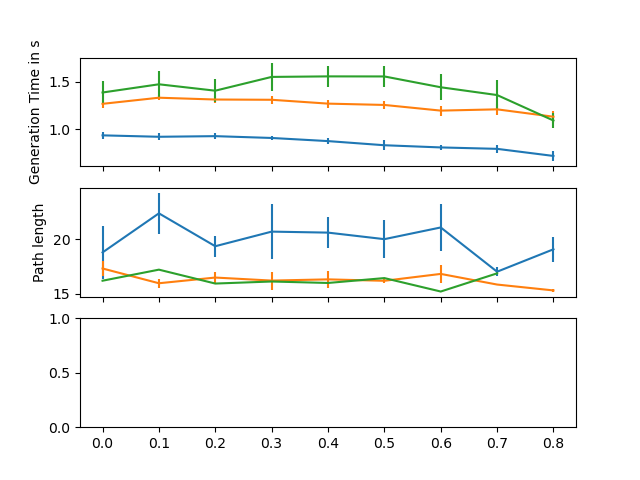

In [4]:

fig, ax = plt.subplots(3,sharex=True)

#plt.plot(bias_list, average_BRRT_times, label = "Generation time")

ax[0].set_ylabel('Generation Time in s')
ax[0].errorbar(bias_list, average_BRRT_times, yerr = std_BRRT_times, label = "RRT")
ax[0].errorbar(bias_list, average_BRRTs_times, yerr = std_BRRTs_times, label = "RRT*")
ax[0].errorbar(bias_list, average_iBRRTs_times, yerr = std_iBRRTs_times, label = "informed RRT*")


#plt.plot(bias_list, average_BRRT_lengths, label = "RRT")
#plt.plot(bias_list, average_BRRTs_lengths, label = "RRT*")

ax[1].set_ylabel('Path length')
ax[1].errorbar(bias_list, average_BRRT_lengths, yerr = std_BRRT_lengths, label = "RRT")
ax[1].errorbar(bias_list, average_BRRTs_lengths, yerr = std_BRRTs_lengths, label = "RRT*")
ax[1].errorbar(bias_list, average_iBRRTs_lengths, yerr = std_iBRRTs_lengths, label = "Informed RRT*")


ax[2].plot(bias_list, BRRT_succes_percentages, label = "RRT")
ax[2].plot(bias_list, BRRTs_succes_percentages, label = "RRT*")
ax[2].plot(bias_list, iBRRTs_succes_percentages, label = "Informed RRT*")
ax[2].set_xlabel('Obstacle Bias')
ax[2].set_ylabel('Succes Rate')

handles, labels = ax[2].get_legend_handles_labels()
fig.set_figheight(10)
fig.legend(handles, labels, loc="lower left", bbox_to_anchor=(0.12,0.1))

